<a href="https://colab.research.google.com/github/saikishan99/Applied_Machine_Learning/blob/main/lstm_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
import warnings
%matplotlib inline

warnings.filterwarnings('ignore')

## Loading the Dataset

In [2]:
df = pd.read_csv('train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [3]:
df['title'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It'

In [4]:
df['text'][0]

'House Dem Aide: We Didn’t Even See Comey’s Letter Until Jason Chaffetz Tweeted It By Darrell Lucus on October 30, 2016 Subscribe Jason Chaffetz on the stump in American Fork, Utah ( image courtesy Michael Jolley, available under a Creative Commons-BY license) \nWith apologies to Keith Olbermann, there is no doubt who the Worst Person in The World is this week–FBI Director James Comey. But according to a House Democratic aide, it looks like we also know who the second-worst person is as well. It turns out that when Comey sent his now-infamous letter announcing that the FBI was looking into emails that may be related to Hillary Clinton’s email server, the ranking Democrats on the relevant committees didn’t hear about it from Comey. They found out via a tweet from one of the Republican committee chairmen. \nAs we now know, Comey notified the Republican chairmen and Democratic ranking members of the House Intelligence, Judiciary, and Oversight committees that his agency was reviewing emai

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


## Data Proprocessing

In [6]:
# drop unnecessary columns
df = df.drop(columns=['id', 'title', 'author'], axis=1)

In [7]:
# drop null values
df = df.dropna(axis=0)

In [8]:
len(df)

20761

In [9]:
# remove special characters and punctuations

In [30]:
df['clean_news'] = df['text'].str.lower()
df['clean_news']

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print \nan iranian woman has been sentenced to...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: clean_news, Length: 20800, dtype: object

In [31]:
df['clean_news'] = df['clean_news'].str.replace('[^A-Za-z0-9\s]', '')
df['clean_news'] = df['clean_news'].str.replace('\n', '')
df['clean_news'] = df['clean_news'].str.replace('\s+', ' ')
df['clean_news']

0        house dem aide: we didn’t even see comey’s let...
1        ever get the feeling your life circles the rou...
2        why the truth might get you fired october 29, ...
3        videos 15 civilians killed in single us airstr...
4        print an iranian woman has been sentenced to s...
                               ...                        
20795    rapper t. i. unloaded on black celebrities who...
20796    when the green bay packers lost to the washing...
20797    the macy’s of today grew from the union of sev...
20798    nato, russia to hold parallel exercises in bal...
20799      david swanson is an author, activist, journa...
Name: clean_news, Length: 20800, dtype: object

In [12]:
from nltk.corpus import stopwords


In [13]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [32]:
# remove stopwords
stop = stopwords.words('english')
df['clean_news'] = df['clean_news'].apply(lambda x: " ".join([word for word in x.split() if word not in stop]))
df.head()

,id,title,author,text,label,clean_news
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,house dem aide: didn’t even see comey’s letter...
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,ever get feeling life circles roundabout rathe...
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,"truth might get fired october 29, 2016 tension..."
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,videos 15 civilians killed single us airstrike...
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,print iranian woman sentenced six years prison...


## Exploratory Data Analysis

In [15]:
import pandas as pd
import torch
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

# Assume `df` is your DataFrame with text and label columns
df = pd.read_csv('train.csv')  # Replace with your actual file path

class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

def preprocess_function(df, text_column, label_column, max_vocab_size=10000, max_length=256):
    # Ensure the text column is of type string and handle missing values
    df[text_column] = df[text_column].fillna('').astype(str)

    # Create tokenizer
    tokenizer = get_tokenizer('basic_english')

    # Build Vocabulary
    def yield_tokens(data_iter):
        for text in data_iter:
            yield tokenizer(text)

    vocab = build_vocab_from_iterator(yield_tokens(df[text_column]), specials=["<unk>", "<pad>"], max_tokens=max_vocab_size)
    vocab.set_default_index(vocab["<unk>"])

    # Tokenize and numericalize texts
    text_pipeline = lambda x: [vocab[token] for token in tokenizer(x)]

    # Truncate and pad sequences
    numericalized_texts = [text_pipeline(text)[:max_length] for text in df[text_column]]  # Truncate
    padded_texts = pad_sequence([torch.tensor(text, dtype=torch.long) for text in numericalized_texts],
                                batch_first=True, padding_value=vocab["<pad>"])

    # Convert labels to tensor
    label_tensor = torch.tensor(df[label_column].values)

    # Create dataset and dataloader
    dataset = NewsDataset(padded_texts, label_tensor)
    dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

    return dataloader, vocab

# Usage:
# Replace 'text' and 'label' with the actual column names in your DataFrame
dataloader, vocab = preprocess_function(df, 'text', 'label')

In [16]:
from sklearn.model_selection import train_test_split

# Assuming df is your DataFrame and it is already preprocessed
train_df, test_df = train_test_split(df, test_size=0.2)
train_dataloader, vocab = preprocess_function(train_df, 'text', 'label')
test_dataloader, _ = preprocess_function(test_df, 'text', 'label')

In [19]:
import torch.nn as nn

# Define the LSTM model
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, dropout):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=1, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, (hidden, _) = self.lstm(embedded)
        hidden = self.dropout(hidden[-1])
        output = self.fc(hidden)
        return output

# Assuming vocab_size is the length of your vocabulary and embedding_dim is 100
# You need to define or import 'vocab' before using it to get 'vocab_size'.
vocab_size = len(vocab)  # Replace 'vocab' with actual vocabulary object or its length
embedding_dim = 100
hidden_dim = 256
output_dim = 1  # Binary classification
dropout = 0.5

model = LSTMClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, dropout)

In [21]:
import torch.optim as optim

# Parameters
num_epochs = 5
learning_rate = 0.001

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()  # Combines a Sigmoid layer and BCELoss in one single class
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Move model to the device (GPU/CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Assuming you have a 'train_dataloader' ready for use
# Training loop
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for texts, labels in train_dataloader:
        texts, labels = texts.to(device), labels.to(device)

        # Forward pass
        outputs = model(texts)
        loss = criterion(outputs.squeeze(), labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss / len(train_dataloader)}')

Epoch 1/5, Loss: 0.6244807991270835
Epoch 2/5, Loss: 0.5192183067019169
Epoch 3/5, Loss: 0.22629178600529065
Epoch 4/5, Loss: 0.1550583447723721
Epoch 5/5, Loss: 0.10634690974839031


In [28]:
# Evaluate the model
model.eval()  # Set the model to evaluation mode
num_corrects = 0
num_samples = 0

with torch.no_grad():
    for texts, labels in test_dataloader:
        texts, labels = texts.to(device), labels.to(device)

        # Forward pass
        outputs = model(texts)
        predictions = torch.round(torch.sigmoid(outputs.squeeze()))  # Squeezing is necessary for BCEWithLogitsLoss
        num_corrects += (predictions == labels).sum().item()
        num_samples += labels.size(0)

print(f'Accuracy of the model on the test set: {num_corrects / num_samples * 100:.2f}%')

Accuracy of the model on the test set: 75.38%


In [29]:
df

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1
...,...,...,...,...,...
20795,20795,Rapper T.I.: Trump a ’Poster Child For White S...,Jerome Hudson,Rapper T. I. unloaded on black celebrities who...,0
20796,20796,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",Benjamin Hoffman,When the Green Bay Packers lost to the Washing...,0
20797,20797,Macy’s Is Said to Receive Takeover Approach by...,Michael J. de la Merced and Rachel Abrams,The Macy’s of today grew from the union of sev...,0
20798,20798,"NATO, Russia To Hold Parallel Exercises In Bal...",Alex Ansary,"NATO, Russia To Hold Parallel Exercises In Bal...",1


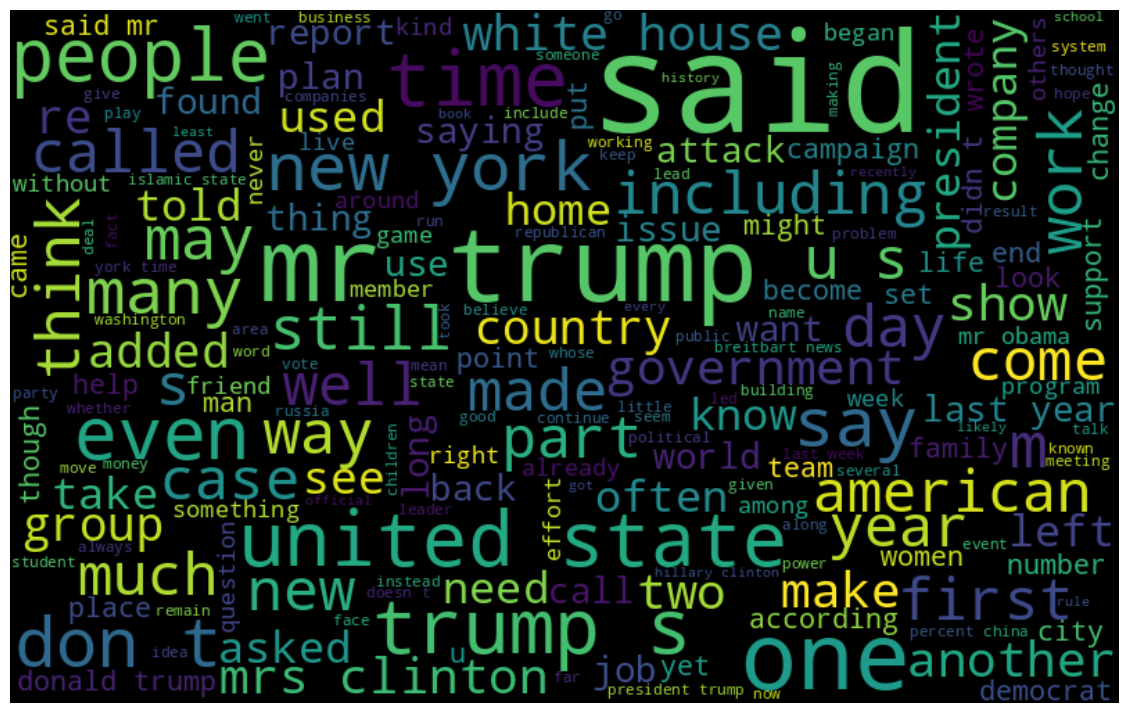

In [33]:
# visualize the frequent words for genuine news
all_words = " ".join([sentence for sentence in df['clean_news'][df['label']==0]])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

# plot the graph
plt.figure(figsize=(15, 9))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

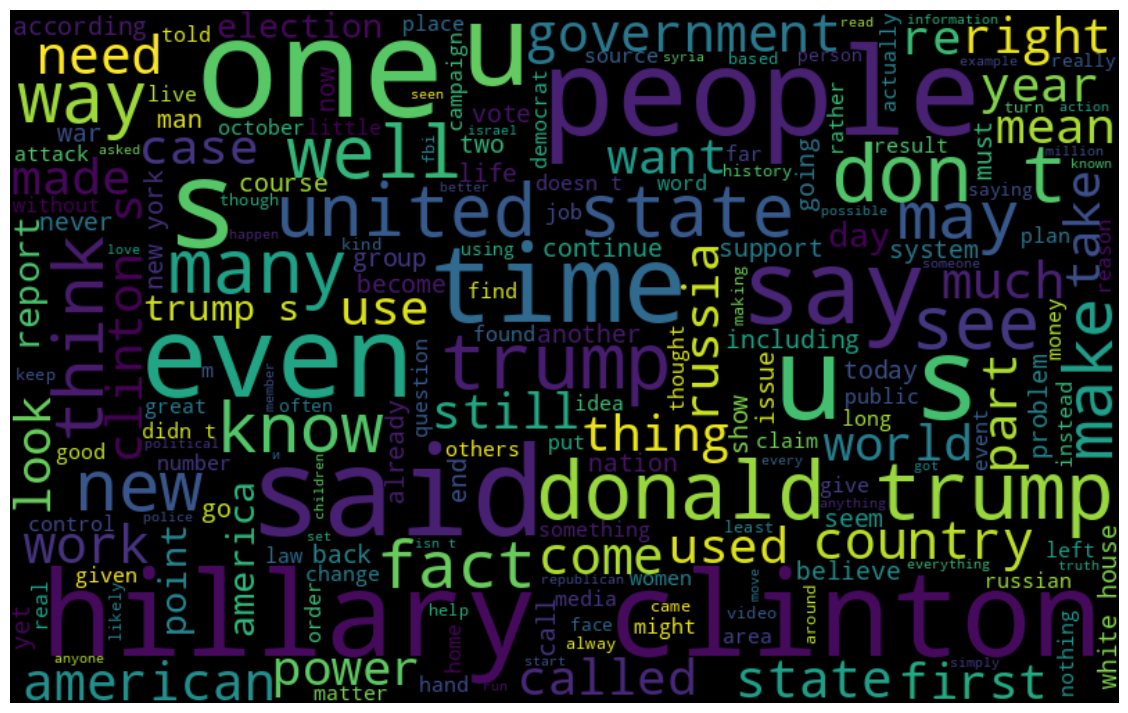

In [34]:
# visualize the frequent words for fake news
if 'clean_news' in df.columns:
    all_words = " ".join(sentence for sentence in df['clean_news'][df['label'] == 1])

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

    # Plot the word cloud
    plt.figure(figsize=(15, 9))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()
else:
    print("Column 'clean_news' does not exist in DataFrame.")

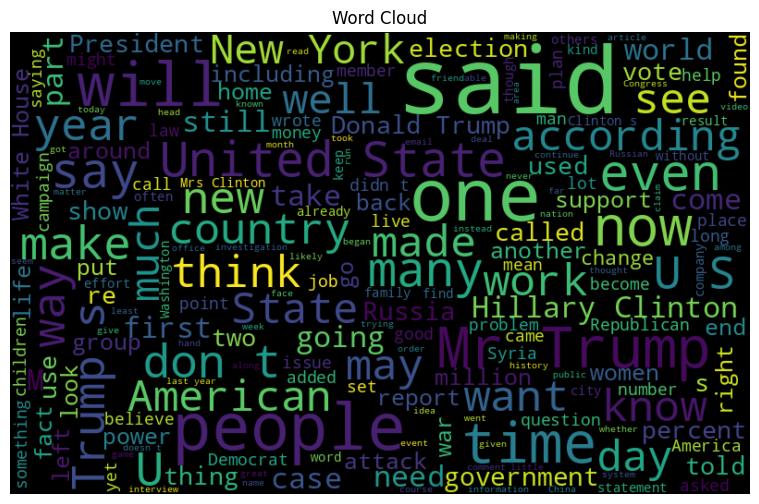

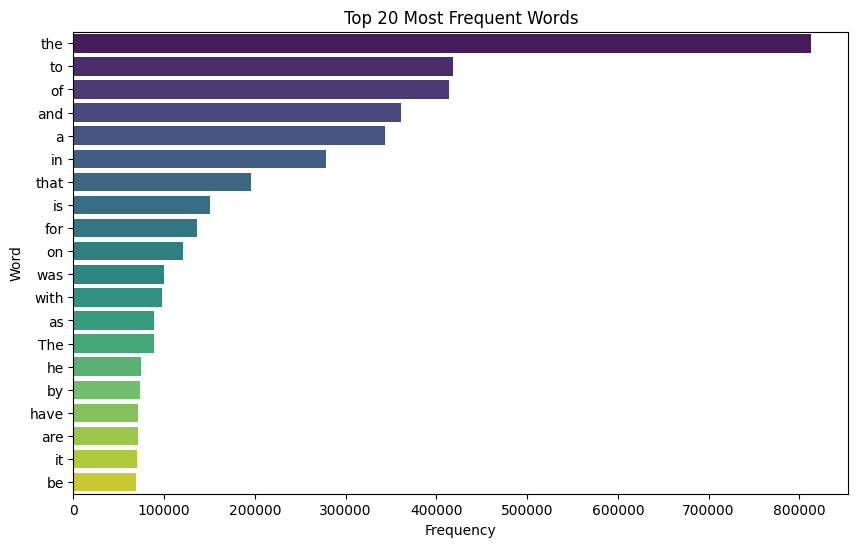

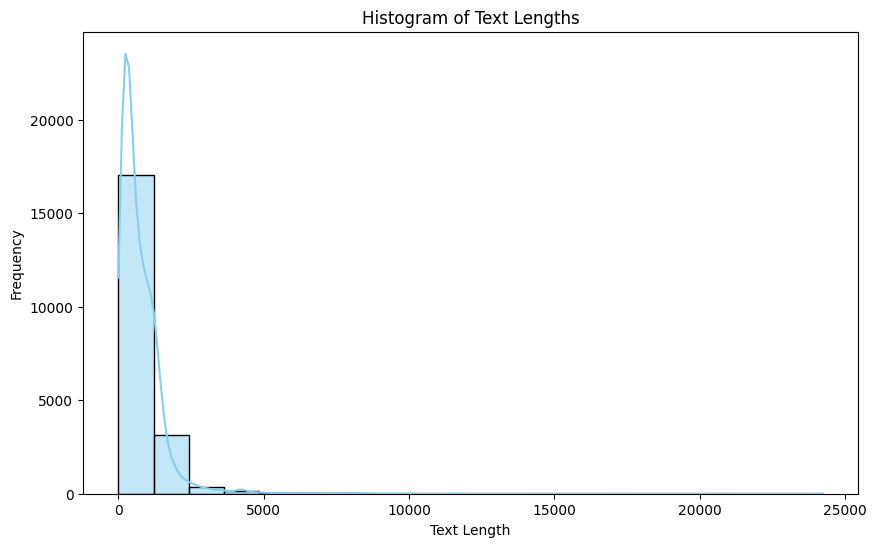

In [35]:
all_text = " ".join(text for text in df['text'])
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_text)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud')
plt.show()

# Example: Plotting word frequencies
word_freq = pd.Series(all_text.split()).value_counts()[:20]
plt.figure(figsize=(10, 6))
sns.barplot(x=word_freq.values, y=word_freq.index, palette='viridis')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()

# Example: Histogram of text lengths
text_lengths = df['text'].apply(lambda x: len(x.split()))
plt.figure(figsize=(10, 6))
sns.histplot(text_lengths, bins=20, kde=True, color='skyblue')
plt.title('Histogram of Text Lengths')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()